In [1]:
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [4]:
# Especificar columnas
relevant_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','Sem','Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante']
num_columns = ['Existencia','fiDesplazamiento','VentaPromedio']
cat_columns = ['SKU','Tienda','FORMATO','Categoria','CLASE','Sem']
target = ['Y_Faltante']

In [5]:
dtype = {'SKU':'object','FORMATO':'object','REGION':'object','Tienda':'object','Categoria':'object','Proveedor':'object','CLASE':'object','SCLASE':'object','Mes':'object','DiaSem':'object','Sem':'object','Existencia':'float','fiDesplazamiento':'float',
\
'VentaPromedio':'float','Y_Faltante':'int'}

In [6]:
# Abrir el archivo
file = 'data.csv'
data = pd.read_csv(file, header=0,low_memory=False, usecols=relevant_columns,dtype=dtype)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 3369980  columns: 10


In [7]:
data = data.dropna()

In [8]:
# Imprime reporte con porcentaje de outliers en nuestro conjunto de datos
outliers = {}
for i in range(6,8):
    min_t = data[data.columns[i]].mean() \
            - (3 * data[data.columns[i]].std())
    max_t = data[data.columns[i]].mean() \
            + (3 * data[data.columns[i]].std())
    count = 0
for j in data[data.columns[i]]:
    if j < min_t or j > max_t:
        count += 1
percentage = count/data.shape[0]
outliers[data.columns[i]] = "%.3f" % percentage
print(outliers)

{'fiDesplazamiento': '0.006'}


yes %: 0.0- no %: 100.0


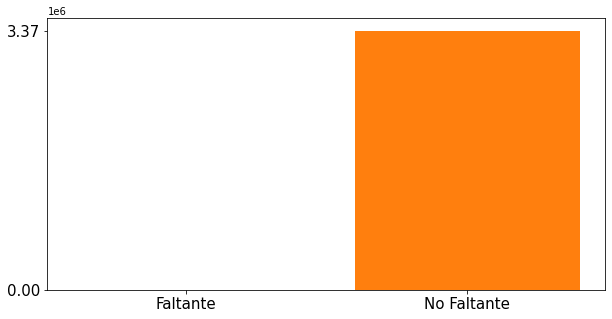

In [9]:
# Verificamos que el conjunto de datos está perfectamente balanceado
# Revisamos la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [10]:
#Balanceamos a 50% - 50% nuestro conjunto de datos.
data_yes = data[data["Y_Faltante"] == 1]
data_no = data[data["Y_Faltante"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
random_state = 0)
balanced_data = pd.concat([data_no, over_sampling], \
axis=0)
data = balanced_data.reset_index(drop=True)

ValueError: a must be greater than 0 unless no samples are taken

yes %: 50.0- no %: 50.0


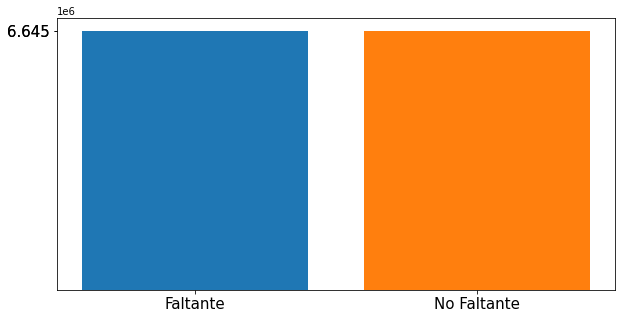

In [ ]:
# Revisamos (de nuevo) la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
X = data.drop('Y_Faltante',axis=1)
y = data.Y_Faltante

In [ ]:
# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=0)
print('Entrenamiento:', X_train.shape[0], ' Prueba:', X_val.shape[0])

Entrenamiento: 11297011  Prueba: 1993591


In [ ]:
indices_categoricos = np.where(X_train.dtypes != float)[0]
indices_categoricos

array([0, 1, 2, 3, 4, 5])

In [ ]:
num_ind = np.where(X_train.dtypes != object)[0]
num_ind

array([6, 7, 8])

## CatBoost

In [ ]:
params = {
    'l2_leaf_reg':int(2.0),
    'iterations': 5000,
    #'eval_metric': [metrics.Accuracy()],
    'custom_loss':[metrics.Accuracy()],
    'random_seed': 0,
    'task_type':'GPU',
    'logging_level': 'Verbose',
    'use_best_model': True,
    #'save_snapshot':True
}
train_pool = X_train, y_train
validate_pool = (X_val, y_val)

In [ ]:
params_with_snapshot = params.copy()


model = CatBoostClassifier(**params_with_snapshot)
model.fit(X_train,y_train,cat_features=indices_categoricos, eval_set=(X_val,y_val),logging_level='Verbose',save_snapshot=True,plot=True)
model.save_model('Ago_model.dump')

print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_val, model.predict(X_val))
))
print('')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

3000:	learn: 0.0403013	test: 0.0255605	best: 0.0255605 (3000)	total: 53m 54s	remaining: 45m 43s
3001:	learn: 0.0403010	test: 0.0255605	best: 0.0255605 (3001)	total: 53m 55s	remaining: 39m 45s
3002:	learn: 0.0403007	test: 0.0255604	best: 0.0255604 (3002)	total: 53m 57s	remaining: 39m 15s
3003:	learn: 0.0403000	test: 0.0255603	best: 0.0255603 (3003)	total: 53m 58s	remaining: 37m 57s
3004:	learn: 0.0402995	test: 0.0255602	best: 0.0255602 (3004)	total: 53m 59s	remaining: 40m 24s
3005:	learn: 0.0402984	test: 0.0255597	best: 0.0255597 (3005)	total: 54m	remaining: 40m
3006:	learn: 0.0402977	test: 0.0255596	best: 0.0255596 (3006)	total: 54m 2s	remaining: 41m 3s
3007:	learn: 0.0402974	test: 0.0255595	best: 0.0255595 (3007)	total: 54m 3s	remaining: 41m 41s
3008:	learn: 0.0402972	test: 0.0255595	best: 0.0255595 (3008)	total: 54m 5s	remaining: 42m 20s
3009:	learn: 0.0402950	test: 0.0255592	best: 0.0255592 (3009)	total: 54m 6s	remaining: 41m 50s
3010:	learn: 0.0402946	test: 0.0255591	best: 0.025559

: 

: 

In [18]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X, y, cat_features=indices_categoricos),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
300:	learn: 0.0641951	test: 0.0430716	best: 0.0430716 (300)	total: 5m 1s	remaining: 12m 59s
301:	learn: 0.0641518	test: 0.0430404	best: 0.0430404 (301)	total: 5m 2s	remaining: 15m 12s
302:	learn: 0.0640649	test: 0.0430175	best: 0.0430175 (302)	total: 5m 4s	remaining: 15m 3s
303:	learn: 0.0639836	test: 0.0430096	best: 0.0430096 (303)	total: 5m 5s	remaining: 14m 15s
304:	learn: 0.0639425	test: 0.0429801	best: 0.0429801 (304)	total: 5m 6s	remaining: 15m 9s
305:	learn: 0.0638596	test: 0.0429548	best: 0.0429548 (305)	total: 5m 8s	remaining: 15m 6s
306:	learn: 0.0636702	test: 0.0422831	best: 0.0422831 (306)	total: 5m 9s	remaining: 14m 43s
307:	learn: 0.0635781	test: 0.0422703	best: 0.0422703 (307)	total: 5m 10s	remaining: 14m 27s
308:	learn: 0.0635618	test: 0.0422574	best: 0.0422574 (308)	total: 5m 11s	remaining: 14m 29s
309:	learn: 0.0634787	test: 0.0422468	best: 0.0422468 (309)	total: 5m 12s	remaining: 14m 23s
310:	learn: 0.0634219	test: 0.0422408	best: 0.0422408 (31

In [19]:
#model = CatBoostClassifier(
#    l2_leaf_reg=int(2.0),
#    custom_loss=[metrics.Accuracy()],
#    random_seed=0,
#    logging_level='Verbose', # Write 'Silent' instead of 'verbose'
#    task_type='GPU',
#    save_snapshot=True,
#    iterations=2000
#)

In [20]:
#model.fit(
#    X_train, y_train,
#    cat_features=indices_categoricos,
#    eval_set=(X_val, y_val),
#    logging_level='Verbose',  # you can uncomment this for text output
#    plot=True
#);

In [ ]:
model.save_model('Ago_model.dump')
model = CatBoostClassifier()
model.load_model('Ago_model.dump');
#model.load_model('experiment.snapshot',format='cbm');

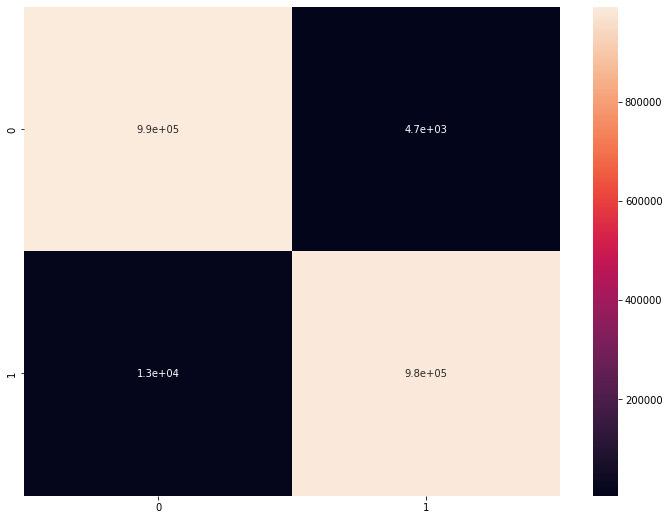

In [ ]:
y_pred = model.predict(X_val)
# Dibujamos también la matriz de confusión para nuestro modelo
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(991672, 4683, 12845, 984391)

In [ ]:
y_pred = model.predict(X_val)

accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9912078254767402
True Positive Rate 0.9871193980161166
Precision 0.987212759963246
Balanced accuracy 0.9912096330175229
f1 score 0.9911755969611994


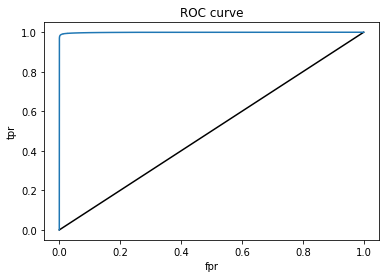

In [ ]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = model.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
copia_general = X_val.copy()
copia_general['Y_Faltante'] = y_val
copia_general['Predicción_Ago'] = model.predict(X_val)
#copia_general.to_csv('Reporte_modelo_grande.csv',index=True)

# Vamos a tratar de incorporar un corrector

In [ ]:
# Se obtienen muy poquitos ejemplos erroneos del conjunto de entrenamiento
#copia = pd.concat([data,data_val],join='inner')
#target = copia.drop('Y_Faltante',axis=1)
#y_pred_train = model.predict(copia)
#pred_cb_train = model.predict_proba(copia)
#pred_cb = pd.DataFrame(y_prob_train).assign(CBPred=pd.Series(y_pred_train))

In [ ]:
# Predicciones del conjunto de entrenamiento
#y_pred_train = model.predict(X_train)
#y_prob_train = model.predict_proba(X_train)
#pred_cb_train = pd.DataFrame(y_prob_train).assign(CBPred=pd.Series(y_pred_train))
#train_target = pd.Series(y_train)

In [ ]:
data_val = pd.concat([X_val,y_val],axis=1)
data_val

,SKU,Tienda,FORMATO,Categoria,CLASE,Sem,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante
9176028,3572903,CHEDRAUI VERACRUZ TEJERIA,CHEDRAUI CD,CAPILARES,CAPILARES,16,0.0,24.0,0.00,1
6242270,3700905,CHEDRAUI SELECTO MEXICO FORTUNA,CHEDRAUI SELECTO,JABONES DE TOCADOR,JABONES DE TOCADOR,23,282.0,27.0,383.94,0
6984405,3461567,CHEDRAUI PALENQUE,CHEDRAUI CD,YOGURTS BEBIBLES,YOGURTS BEBIBLES,18,-3.0,107.0,1355.69,1
206640,3102371,CHEDRAUI PUEBLA CAPU,CHEDRAUI CD,TINTES DAMA,TINTES DAMA,18,2.0,24.0,618.00,0
12557368,3680787,CHEDRAUI TEPIC NAYARIT,CHEDRAUI CD,PAN,PAN,20,2.0,9.0,238.50,1
...,...,...,...,...,...,...,...,...,...,...
10658993,3067785,CHEDRAUI COATZACOALCOS UNIVERSIDAD,CHEDRAUI CD,CRISTALERIA,CRISTALERIA,14,29.0,40.0,1051.20,1
107212,3605423,CHEDRAUI PASEO QUERETARO,CHEDRAUI AB,CREMAS Y TRATAMIENTOS,CREMAS Y TRATAMIENTOS,17,3.0,6.0,564.00,0
9323211,3685738,SUPER CHEDRAUI TEPEACA,SUPER CHEDRAUI CD,CREMA,CREMA,7,6.0,57.0,1026.00,1
11403999,3396305,SUPER CHEDRAUI TEPEACA,SUPER CHEDRAUI CD,DESODORANTES DAMA,DESODORANTES DAMA,19,0.0,13.0,0.00,1


In [ ]:
nuevos_datos = data_val.copy()
nuevos_datos['Predicción_Ago'] = model.predict(nuevos_datos.drop('Y_Faltante',axis=1))

In [ ]:
nuevos_datos[['0','1']] = model.predict_proba(nuevos_datos.drop(['Y_Faltante','Predicción_Ago'],axis=1))

In [ ]:
# 0 va a indicar acuerdo y 1 indica desacuerdo
faltante_real = nuevos_datos['Y_Faltante']
faltante_predicho = nuevos_datos['Predicción_Ago']
verdaderos_positivos = (faltante_real + faltante_predicho) % 2
nuevos_datos['Acuerdo'] = verdaderos_positivos 

In [ ]:
nuevos_datos

,SKU,Tienda,FORMATO,Categoria,CLASE,Sem,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante,Predicción_Ago,0,1,Acuerdo
9176028,3572903,CHEDRAUI VERACRUZ TEJERIA,CHEDRAUI CD,CAPILARES,CAPILARES,16,0.0,24.0,0.00,1,1,9.486572e-07,0.999999,0
6242270,3700905,CHEDRAUI SELECTO MEXICO FORTUNA,CHEDRAUI SELECTO,JABONES DE TOCADOR,JABONES DE TOCADOR,23,282.0,27.0,383.94,0,0,9.999655e-01,0.000035,0
6984405,3461567,CHEDRAUI PALENQUE,CHEDRAUI CD,YOGURTS BEBIBLES,YOGURTS BEBIBLES,18,-3.0,107.0,1355.69,1,1,1.370374e-05,0.999986,0
206640,3102371,CHEDRAUI PUEBLA CAPU,CHEDRAUI CD,TINTES DAMA,TINTES DAMA,18,2.0,24.0,618.00,0,0,9.933501e-01,0.006650,0
12557368,3680787,CHEDRAUI TEPIC NAYARIT,CHEDRAUI CD,PAN,PAN,20,2.0,9.0,238.50,1,1,7.253938e-03,0.992746,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10658993,3067785,CHEDRAUI COATZACOALCOS UNIVERSIDAD,CHEDRAUI CD,CRISTALERIA,CRISTALERIA,14,29.0,40.0,1051.20,1,1,1.549579e-06,0.999998,0
107212,3605423,CHEDRAUI PASEO QUERETARO,CHEDRAUI AB,CREMAS Y TRATAMIENTOS,CREMAS Y TRATAMIENTOS,17,3.0,6.0,564.00,0,0,9.971759e-01,0.002824,0
9323211,3685738,SUPER CHEDRAUI TEPEACA,SUPER CHEDRAUI CD,CREMA,CREMA,7,6.0,57.0,1026.00,1,1,3.774459e-02,0.962255,0
11403999,3396305,SUPER CHEDRAUI TEPEACA,SUPER CHEDRAUI CD,DESODORANTES DAMA,DESODORANTES DAMA,19,0.0,13.0,0.00,1,1,7.378051e-07,0.999999,0


In [ ]:
nuevos_datos.to_csv('Reporte_modelo_grande.csv',index=True)

In [ ]:
# Aquí reportamos el numero de acuerdos y desacuerdos
verdaderos_positivos.value_counts()

0    1976063
1      17528
dtype: int64

yes %: 0.8792174523259786- no %: 99.12078254767403


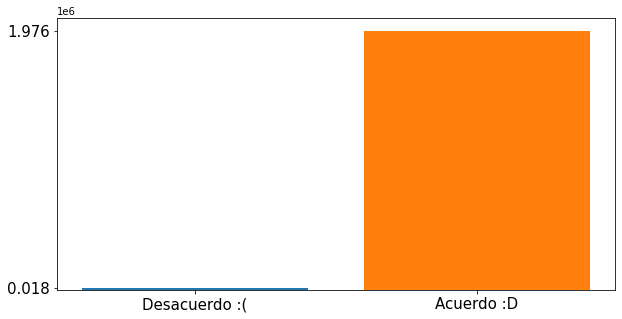

In [ ]:
# Revisamos (de nuevo) la proporción de datos
target = verdaderos_positivos
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Desacuerdo :(", yes)
plt.bar("Acuerdo :D", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
buenas = nuevos_datos[nuevos_datos['Acuerdo']==0]
malas = nuevos_datos[nuevos_datos['Acuerdo']==1]

In [ ]:
len(buenas)

1976063

In [ ]:
len(malas)

17528

### Construímos una función que extrae un subconjunto aleatorio de registros de un frame

In [ ]:
import math 
import random


# 'frame_bueno' vá a ser el frame del cual extraemos y 'frame_malo' sólo será importante por su tamaño 
def extrae(frame_bueno,frame_malo):
    frame = pd.DataFrame()
    tamaño_de_malas = len(frame_malo)
    for i in range(tamaño_de_malas):
        a = random.randint(1,tamaño_de_malas-2)
        nuevo = frame_bueno.iloc[a:a+1]
        frame = pd.concat([frame,nuevo],ignore_index=True)
    return frame

In [ ]:
pieza = extrae(buenas,malas)

In [ ]:
# El argumento de extrae vá a ser "y" donde  x = 100% - y & "y" es el porcentaje (del total) que quieres extraer
frame_final = pd.concat([malas,pieza],axis=0)

In [ ]:
frame_final

,SKU,Tienda,FORMATO,Categoria,CLASE,Sem,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante,Predicción_Ago,0,1,Acuerdo
3417419,3613597,CHEDRAUI COMALCALCO NORTE,CHEDRAUI CD,SHAMPOOS Y ACONDICIONADOR,SHAMPOOS Y ACONDICIONADOR,3,0.0,12.0,0.00,0,1,4.332691e-02,0.956673,1
12404009,3090487,SUPER CHE ENCUENTRO TLALNEPANTLA,SUPER CHE CD,PASTAS PARA SOPA,PASTAS PARA SOPA,21,3.0,37.0,912.79,1,0,9.295329e-01,0.070467,1
10585147,3091454,SUPER CHEDRAUI SELECTO MEXICO OCEANIA,SUPER CHEDRAUI CD,VINOS TINTOS,VINOS TINTOS,12,4.0,12.0,1938.00,1,0,9.816823e-01,0.018318,1
11227108,3020882,CHEDRAUI MEXICO LOMAS ESTRELLA,CHEDRAUI CD,JABONES DE TOCADOR,JABONES DE TOCADOR,5,3.0,11.0,506.00,1,0,9.364818e-01,0.063518,1
10278479,3592566,CHEDRAUI ACAPULCO PIE DE LA CUESTA,CHEDRAUI CD,BOTANAS,BOTANAS,9,13.0,22.0,548.24,1,0,9.716488e-01,0.028351,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17523,3613596,CHEDRAUI SELECTO VERACRUZ EL DORADO,CHEDRAUI SELECTO,CREMAS EMPACADAS,CREMAS EMPACADAS,22,12.0,122.0,8296.00,1,1,1.520442e-03,0.998480,0
17524,3421301,CHEDRAUI CORDOBA CRYSTAL,CHEDRAUI AB,TINTES DAMA,TINTES DAMA,23,17.0,8.0,344.96,0,0,9.998993e-01,0.000101,0
17525,3419939,CHEDRAUI ORIZABA CENTRO,CHEDRAUI AB,VELAS Y VELADORAS,VELAS Y VELADORAS,21,16.0,41.0,4522.71,1,1,4.152394e-07,1.000000,0
17526,3363291,SUPER CHEDRAUI SELECTO MEXICO OCEANIA,SUPER CHEDRAUI CD,TINTES DAMA,TINTES DAMA,18,12.0,15.0,1008.75,1,1,4.218154e-06,0.999996,0


In [ ]:
frame_final.to_csv('modelo_enorme_balanceado.csv',index=True)

### Aquí la idea es construir una muestra que sea 50 vs 50 tanto en acuerdo
### Posiblemente sea interesante también hacer una prueba con un modelo que tenga 50/50 tanto en acuerdo como en faltante contra no faltante 

yes %: 50.0- no %: 50.0


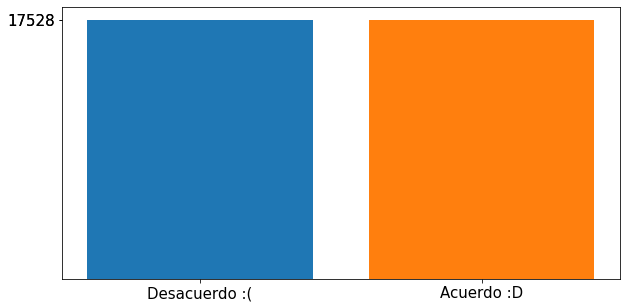

In [ ]:
# Revisamos la proporción de datos
target = frame_final['Acuerdo']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Desacuerdo :(", yes)
plt.bar("Acuerdo :D", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
frame_final

,SKU,Tienda,FORMATO,Categoria,CLASE,Sem,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante,Predicción_Ago,0,1,Acuerdo
3417419,3613597,CHEDRAUI COMALCALCO NORTE,CHEDRAUI CD,SHAMPOOS Y ACONDICIONADOR,SHAMPOOS Y ACONDICIONADOR,3,0.0,12.0,0.00,0,1,4.332691e-02,0.956673,1
12404009,3090487,SUPER CHE ENCUENTRO TLALNEPANTLA,SUPER CHE CD,PASTAS PARA SOPA,PASTAS PARA SOPA,21,3.0,37.0,912.79,1,0,9.295329e-01,0.070467,1
10585147,3091454,SUPER CHEDRAUI SELECTO MEXICO OCEANIA,SUPER CHEDRAUI CD,VINOS TINTOS,VINOS TINTOS,12,4.0,12.0,1938.00,1,0,9.816823e-01,0.018318,1
11227108,3020882,CHEDRAUI MEXICO LOMAS ESTRELLA,CHEDRAUI CD,JABONES DE TOCADOR,JABONES DE TOCADOR,5,3.0,11.0,506.00,1,0,9.364818e-01,0.063518,1
10278479,3592566,CHEDRAUI ACAPULCO PIE DE LA CUESTA,CHEDRAUI CD,BOTANAS,BOTANAS,9,13.0,22.0,548.24,1,0,9.716488e-01,0.028351,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17523,3613596,CHEDRAUI SELECTO VERACRUZ EL DORADO,CHEDRAUI SELECTO,CREMAS EMPACADAS,CREMAS EMPACADAS,22,12.0,122.0,8296.00,1,1,1.520442e-03,0.998480,0
17524,3421301,CHEDRAUI CORDOBA CRYSTAL,CHEDRAUI AB,TINTES DAMA,TINTES DAMA,23,17.0,8.0,344.96,0,0,9.998993e-01,0.000101,0
17525,3419939,CHEDRAUI ORIZABA CENTRO,CHEDRAUI AB,VELAS Y VELADORAS,VELAS Y VELADORAS,21,16.0,41.0,4522.71,1,1,4.152394e-07,1.000000,0
17526,3363291,SUPER CHEDRAUI SELECTO MEXICO OCEANIA,SUPER CHEDRAUI CD,TINTES DAMA,TINTES DAMA,18,12.0,15.0,1008.75,1,1,4.218154e-06,0.999996,0


In [ ]:
frame_final_features = frame_final[['Existencia','fiDesplazamiento','VentaPromedio','Predicción_Ago','0','1']]
frame_final_target = frame_final.Y_Faltante

In [ ]:
# Aislamos las variables numéricas y realizamos un min-max scaling sobre ellas
categorical = frame_final_features.drop(columns=['Existencia','fiDesplazamiento','VentaPromedio'])
numerical = frame_final_features[['Existencia','fiDesplazamiento','VentaPromedio']]
numerical_scaled = (numerical - numerical.min())/(numerical.max() - numerical.min())
frame_final_features = pd.concat([categorical,numerical_scaled], axis=1)

In [ ]:
# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X_train, X_val, y_train, y_val = train_test_split(frame_final_features, frame_final_target, test_size=0.2, random_state=0)
print('Entrenamiento:', X_train.shape[0], ' Prueba:', X_val.shape[0])

Entrenamiento: 28044  Prueba: 7012


## Pendiente: ¿Qué pasa si aumentas el número de variables para entrenar el modelo (por ejemplo VentaPromedio)?

# Implementamos un Random Forest como corrector 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
rfc.predict(X_val)
acc_train = rfc.score(X_train,y_train)
acc_test = rfc.score(X_val,y_val)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.9999, Presición validación: 0.9501


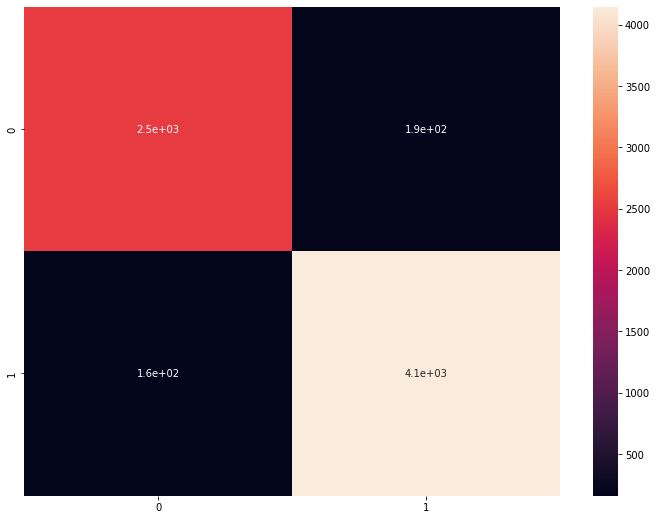

In [ ]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = rfc.predict(X_val)
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred)
precision = precision_score(y_val,y_pred)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9500855675984028
True Positive Rate 0.963091922005571
Precision 0.9559907834101382
Balanced accuracy 0.9462279136655074
f1 score 0.959528214616096


In [ ]:
X_val

,Predicción_Ago,0,1,Existencia,fiDesplazamiento,VentaPromedio
4560,0,0.999762,0.000238,0.194257,0.000461,0.005752
10310824,0,0.964913,0.035087,0.194742,0.012402,0.011255
7314,0,0.999861,0.000139,0.194742,0.000923,0.006332
11669,0,0.999953,0.000047,0.194473,0.000808,0.006235
13049,1,0.000002,0.999998,0.196412,0.000577,0.006081
...,...,...,...,...,...,...
1916362,1,0.472684,0.527316,0.193934,0.000635,0.006465
3574453,1,0.212008,0.787992,0.193934,0.001038,0.005713
15464,1,0.000585,0.999415,0.193934,0.000433,0.005713
12763007,0,0.551903,0.448097,0.194742,0.002221,0.007817


In [ ]:
corrector_data = X_val.copy()
corrector_data['RF_Prediction'] = rfc.predict(corrector_data)
corrector_data['Y_Faltante'] = y_val
corrector_data.to_csv('rf_enorme.csv',index=True)

In [ ]:
corrector_data

,Predicción_Ago,0,1,Existencia,fiDesplazamiento,VentaPromedio,RF_Prediction,Y_Faltante
4560,0,0.999762,0.000238,0.194257,0.000461,0.005752,0,0
10310824,0,0.964913,0.035087,0.194742,0.012402,0.011255,1,1
7314,0,0.999861,0.000139,0.194742,0.000923,0.006332,0,0
11669,0,0.999953,0.000047,0.194473,0.000808,0.006235,0,0
13049,1,0.000002,0.999998,0.196412,0.000577,0.006081,1,1
...,...,...,...,...,...,...,...,...
1916362,1,0.472684,0.527316,0.193934,0.000635,0.006465,0,0
3574453,1,0.212008,0.787992,0.193934,0.001038,0.005713,0,0
15464,1,0.000585,0.999415,0.193934,0.000433,0.005713,1,1
12763007,0,0.551903,0.448097,0.194742,0.002221,0.007817,1,1


# Local Cascade Ensemble

In [ ]:
# Entrenamos un LCE con los parametros por defecto
from lce import LCEClassifier
lce = LCEClassifier(n_jobs=-1, random_state=123)
lce.fit(X_train, y_train)
lce.predict(X_val)
acc_train = lce.score(X_train,y_train)
acc_test = lce.score(X_val,y_val)
print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.9929, Presición validación: 0.9458


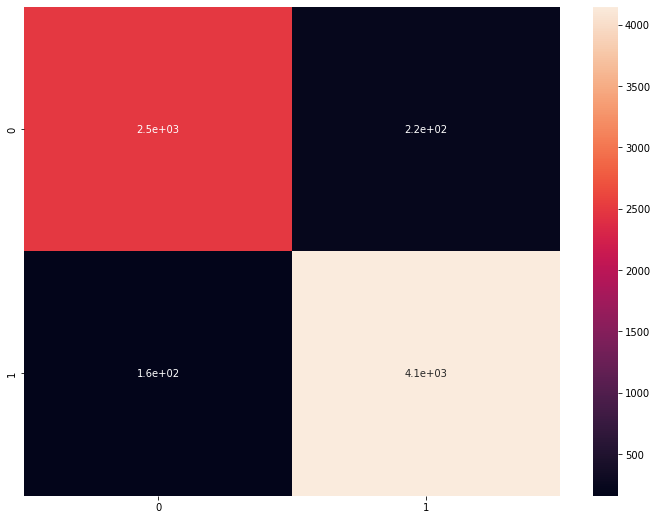

In [ ]:
#from sklearn.metrics import confusion_matrix
y_pred = lce.predict(X_val)
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(2485, 219, 161, 4147)

In [ ]:
accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred)
precision = precision_score(y_val,y_pred)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9458071876782659
True Positive Rate 0.962627669452182
Precision 0.9498396701786532
Balanced accuracy 0.9408182725959136
f1 score 0.9561909153792943


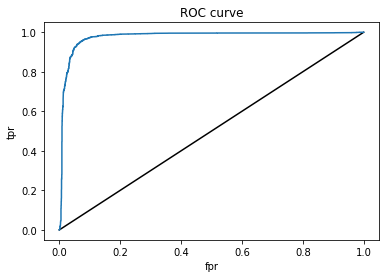

In [ ]:
#from sklearn.metrics import roc_curve
y_pred_proba = lce.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
corrector_data = X_val.copy()
corrector_data['LCE_Prediction'] = lce.predict(corrector_data)
corrector_data['Y_Faltante'] = y_val
corrector_data.to_csv('LCE_enorme.csv',index=True)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.predict(X_val)
acc_train = nb.score(X_train,y_train)
acc_test = nb.score(X_val,y_val)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.6256, Presición validación: 0.6305


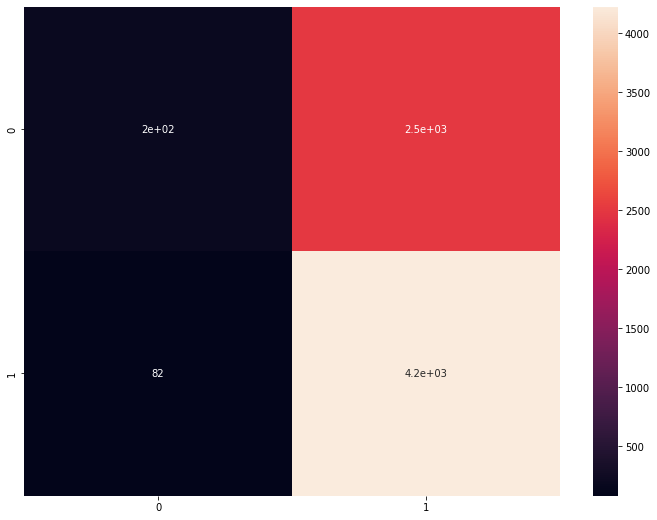

In [ ]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = nb.predict(X_val)
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(195, 2509, 82, 4226)

In [ ]:
accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred)
precision = precision_score(y_val,y_pred)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.6304905875641758
True Positive Rate 0.9809656453110492
Precision 0.6274684484038604
Balanced accuracy 0.526540514963217
f1 score 0.7653717286969122


In [ ]:
corrector_data = X_val.copy()
corrector_data['XGB_Prediction'] = nb.predict(corrector_data)
corrector_data['Y_Faltante'] = y_val
corrector_data.to_csv('nb_enorme.csv',index=True)

# Usamos un XGBClassifier

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
xgb.fit(X_train, y_train)
xgb.predict(X_val)
acc_train = xgb.score(X_train,y_train)
acc_test = xgb.score(X_val,y_val)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precisión entrenamiento: 0.9572, Presición validación: 0.9334


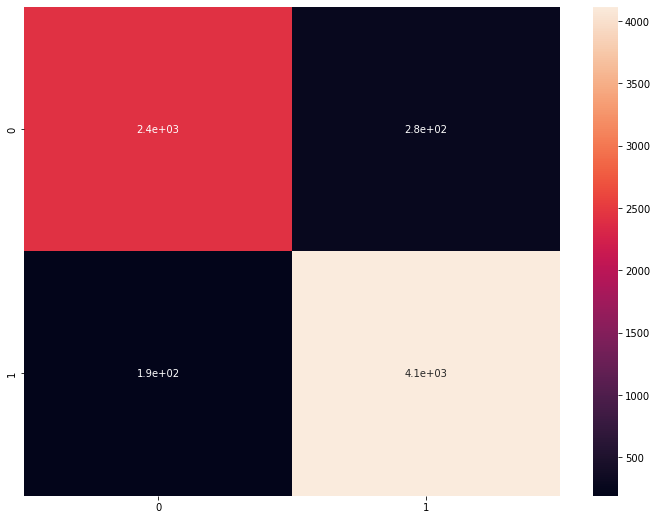

In [ ]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = xgb.predict(X_val)
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(2429, 275, 192, 4116)

In [ ]:
accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred)
precision = precision_score(y_val,y_pred)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9333998859098688
True Positive Rate 0.9554317548746518
Precision 0.9373718970621726
Balanced accuracy 0.9268652857213495
f1 score 0.9463156684676399


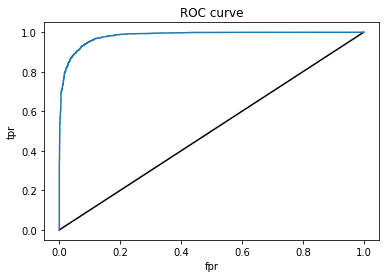

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = xgb.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
corrector_data = X_val.copy()
corrector_data['XGB_Prediction'] = xgb.predict(corrector_data)
corrector_data['Y_Faltante'] = y_val
corrector_data.to_csv('xgb_enorme.csv',index=True)

## Vanilla LightGBM

In [ ]:
#from sklearn.ensemble import GradientBoostClassifier
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state=0)
lgbm.fit(X_train, y_train)
lgbm.predict(X_val)
acc_train = lgbm.score(X_train,y_train)
acc_test = lgbm.score(X_val,y_val)

print(f'Precisión entrenamiento: {acc_train.round(4)}, Presición validación: {acc_test.round(4)}')

Precisión entrenamiento: 0.9357, Presición validación: 0.9254


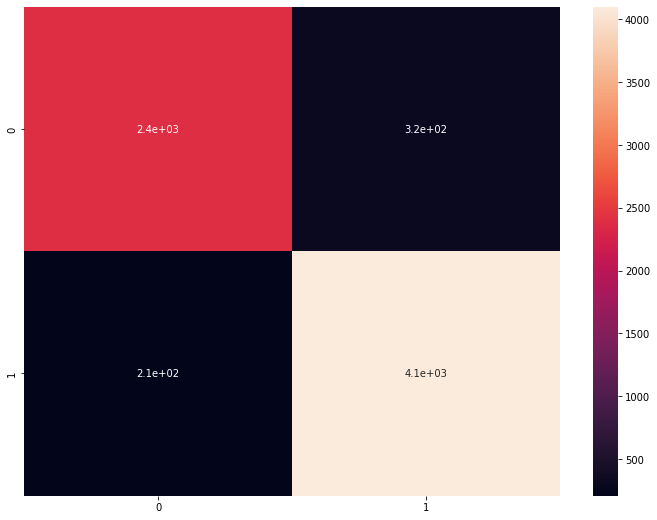

In [ ]:
from sklearn.metrics import confusion_matrix
#y_test = label_test
y_pred = lgbm.predict(X_val)
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

In [ ]:
accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred)
precision = precision_score(y_val,y_pred)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9254135767256132
True Positive Rate 0.9521819870009285
Precision 0.92826431319303
Balanced accuracy 0.9174741295951387
f1 score 0.9400710438867881


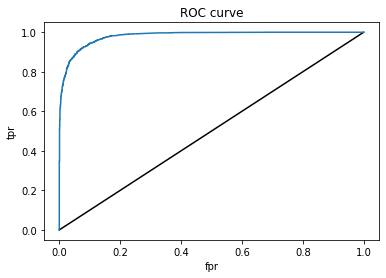

In [ ]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = lgbm.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
corrector_data = X_val.copy()
corrector_data['lgbm_Prediction'] = lgbm.predict(corrector_data)
corrector_data['Y_Faltante'] = y_val
corrector_data.to_csv('lgbm_enorme.csv',index=True)

## CatBoost

In [ ]:
X_val

,Predicción_Ago,0,1,Existencia,fiDesplazamiento,VentaPromedio
4560,0,0.999762,0.000238,0.194257,0.000461,0.005752
10310824,0,0.964913,0.035087,0.194742,0.012402,0.011255
7314,0,0.999861,0.000139,0.194742,0.000923,0.006332
11669,0,0.999953,0.000047,0.194473,0.000808,0.006235
13049,1,0.000002,0.999998,0.196412,0.000577,0.006081
...,...,...,...,...,...,...
1916362,1,0.472684,0.527316,0.193934,0.000635,0.006465
3574453,1,0.212008,0.787992,0.193934,0.001038,0.005713
15464,1,0.000585,0.999415,0.193934,0.000433,0.005713
12763007,0,0.551903,0.448097,0.194742,0.002221,0.007817


In [ ]:
gato = CatBoostClassifier(
    l2_leaf_reg=int(1.0),
    custom_loss=[metrics.Accuracy()],
    random_seed=0,
    logging_level='Verbose', # Write 'Silent' instead of 'verbose'
    task_type='GPU',
    #iterations=190
)

In [ ]:
gato.fit(
    X_train, y_train,
    cat_features=['Predicción_Ago'],
    eval_set=(X_val, y_val),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6519341	test: 0.6516046	best: 0.6516046 (0)	total: 49.2ms	remaining: 49.2s
1:	learn: 0.6127301	test: 0.6118567	best: 0.6118567 (1)	total: 75.8ms	remaining: 37.8s
2:	learn: 0.5762167	test: 0.5748687	best: 0.5748687 (2)	total: 103ms	remaining: 34.1s
3:	learn: 0.5458157	test: 0.5441663	best: 0.5441663 (3)	total: 122ms	remaining: 30.5s
4:	learn: 0.5184100	test: 0.5161351	best: 0.5161351 (4)	total: 149ms	remaining: 29.7s
5:	learn: 0.4923013	test: 0.4898676	best: 0.4898676 (5)	total: 175ms	remaining: 29s
6:	learn: 0.4696218	test: 0.4666752	best: 0.4666752 (6)	total: 199ms	remaining: 28.2s
7:	learn: 0.4490281	test: 0.4456357	best: 0.4456357 (7)	total: 216ms	remaining: 26.8s
8:	learn: 0.4296085	test: 0.4256647	best: 0.4256647 (8)	total: 241ms	remaining: 26.5s
9:	learn: 0.4119790	test: 0.4076767	best: 0.4076767 (9)	total: 265ms	remaining: 26.2s
10:	learn: 0.3952241	test: 0.3905614	best: 0.3905614 (10)	total: 289ms	remaining: 26s
11:	learn: 0.3787636	test: 0.3737696	best: 0.3737696 (

In [ ]:
y_pred = gato.predict(X_val)
prediction_probs = gato.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9235596120935539
True Positive Rate 0.9496285979572887
Precision 0.9166026133743275
Balanced accuracy 0.9158276125881117
f1 score 0.9385180087175957


In [ ]:
# Calculamos las entradas de la matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
tn,fp,fn,tp

(2385, 319, 217, 4091)

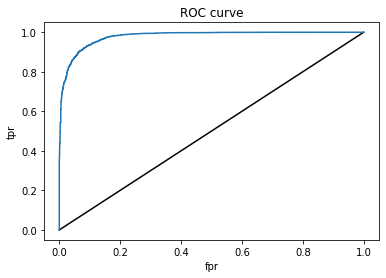

In [ ]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = gato.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
corrector_data = X_val.copy()
corrector_data['XGB_Prediction'] = gato.predict(corrector_data)
corrector_data['Y_Faltante'] = y_val
corrector_data.to_csv('gato_enorme.csv',index=True)

### Usamos una red neuronal como corrector

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [ ]:
class Red_Ago(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 500)
        self.hidden_2 = nn.Linear(500, 500)
        self.hidden_3 = nn.Linear(500, 100)
        self.hidden_4 = nn.Linear(100, 10)
        self.hidden_5 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

        self.batchnorm1 = nn.BatchNorm1d(500)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.batchnorm3 = nn.BatchNorm1d(100)
        self.batchnorm4 = nn.BatchNorm1d(10)

    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = self.batchnorm1(z)
        z = F.relu(self.hidden_2(z))
        z = self.batchnorm2(z)
        z = F.relu(self.hidden_3(z))
        z = self.batchnorm3(z)
        z = F.relu(self.hidden_4(z))
        z = self.batchnorm4(z)
        z = F.relu(self.hidden_5(z))

        out = F.log_softmax(self.output(z), dim=1)

        return out

In [ ]:
# Una red mucho más profunda
class Red_Ago3(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 500)
        self.hidden_2 = nn.Linear(500, 500)
        self.hidden_3 = nn.Linear(500, 100)
        self.hidden_4 = nn.Linear(100, 100)
        self.hidden_5 = nn.Linear(100, 100)
        self.hidden_6 = nn.Linear(100, 10)
        self.hidden_7 = nn.Linear(10, 10)
        self.hidden_8 = nn.Linear(10, 10)
        self.hidden_9 = nn.Linear(10, 10)
        self.hidden_10 = nn.Linear(10, 10)
        self.hidden_11 = nn.Linear(10, 10)
        self.hidden_12 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)

        self.batchnorm1 = nn.BatchNorm1d(500)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.batchnorm3 = nn.BatchNorm1d(100)
        self.batchnorm4 = nn.BatchNorm1d(100)
        self.batchnorm5 = nn.BatchNorm1d(100)
        self.batchnorm6 = nn.BatchNorm1d(10)
        self.batchnorm7 = nn.BatchNorm1d(10)
        self.batchnorm8 = nn.BatchNorm1d(10)
        self.batchnorm9 = nn.BatchNorm1d(10)
        self.batchnorm10 = nn.BatchNorm1d(10)
        self.batchnorm11 = nn.BatchNorm1d(10)

    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = self.batchnorm1(z)
        z = F.relu(self.hidden_2(z))
        z = self.batchnorm2(z)
        z = F.relu(self.hidden_3(z))
        z = self.batchnorm3(z)
        z = F.relu(self.hidden_4(z))
        z = self.batchnorm4(z)
        z = F.relu(self.hidden_5(z))
        z = self.batchnorm5(z)
        z = F.relu(self.hidden_6(z))
        z = self.batchnorm6(z)
        z = F.relu(self.hidden_7(z))
        z = self.batchnorm7(z)
        z = F.relu(self.hidden_8(z))
        z = self.batchnorm8(z)
        z= F.relu(self.hidden_9(z))
        z = self.batchnorm9(z)
        z = F.relu(self.hidden_10(z))
        z = self.batchnorm10(z)
        z = F.relu(self.hidden_11(z))
        z = self.batchnorm11(z)
        z = F.relu(self.hidden_12(z))

        out = F.log_softmax(self.output(z), dim=1)

        return out

In [ ]:
frame_final_train = frame_final[['Existencia','fiDesplazamiento','VentaPromedio','Predicción_Ago','Predicción_Ago','0','1']]
frame_final_val = frame_final.Y_Faltante

In [ ]:
# Aislamos las variables numéricas y realizamos un min-max scaling sobre ellas
categorical = frame_final_train.drop(columns=['Existencia','fiDesplazamiento','VentaPromedio'])
numerical = frame_final_train[['Existencia','fiDesplazamiento','VentaPromedio']]
numerical_scaled = (numerical - numerical.min())/(numerical.max() - numerical.min())
#frame_final_train = pd.concat([categorical,numerical_scaled], axis=1)

In [ ]:
frame_final_train = pd.concat([categorical,numerical_scaled], axis=1)

In [ ]:
# Se construyen los conjuntos de entrenamiento y prueba sobre los que se aplicarán algoritmos de machine learning
X1_train, X1_val, y1_train, y1_val = train_test_split(frame_final_train, frame_final_val, test_size=0.2, random_state=0)
print('Entrenamiento:', X1_train.shape[0], ' Prueba:', X1_val.shape[0])

Entrenamiento: 28044  Prueba: 7012


In [ ]:
X_test_torch = torch.tensor(X1_val.values).float()
y_test_torch = torch.tensor(y1_val.values)

In [ ]:
model1 = Red_Ago3(X1_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model1.parameters(), lr=0.01)

epochs = 300
batch_size = 3000


train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1,epochs+1):
    X_, y_ = shuffle(X1_train, y1_train)
    running_loss = 0
    running_acc = 0
    iterations = 0

    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)

        log_ps = model1(X_batch) 
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch.to('cpu'), top_class.to('cpu'))

    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model1(X_test_torch)
        dev_loss = criterion(log_dev, y_test_torch)

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_test_torch.to('cpu'), top_class_dev.to('cpu'))

    if e%20 == 0 or e == 1:
        x_axis.append(e)

        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_loss)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc)

        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.6f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.6f}.. ".format(dev_loss),
              "Training Accuracy: {:.6f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.6f}".format(acc))

Epoch: 1/300..  Training Loss: 0.618992..  Validation Loss: 0.417224..  Training Accuracy: 0.686829..  Validation Accuracy: 0.918283
Epoch: 20/300..  Training Loss: 0.198908..  Validation Loss: 0.190468..  Training Accuracy: 0.917195..  Validation Accuracy: 0.919139
Epoch: 40/300..  Training Loss: 0.201117..  Validation Loss: 0.196890..  Training Accuracy: 0.917637..  Validation Accuracy: 0.919852
Epoch: 60/300..  Training Loss: 0.198920..  Validation Loss: 0.190422..  Training Accuracy: 0.917150..  Validation Accuracy: 0.920280
Epoch: 80/300..  Training Loss: 0.196632..  Validation Loss: 0.187752..  Training Accuracy: 0.917105..  Validation Accuracy: 0.920565
Epoch: 100/300..  Training Loss: 0.205127..  Validation Loss: 0.206196..  Training Accuracy: 0.917520..  Validation Accuracy: 0.911010
Epoch: 120/300..  Training Loss: 0.200694..  Validation Loss: 0.190305..  Training Accuracy: 0.917738..  Validation Accuracy: 0.920993
Epoch: 140/300..  Training Loss: 0.199606..  Validation Loss:

In [ ]:
# Efectuamos un análisis de errores para la red neuronal RedAgo1
log_dev  = model1(X_test_torch)
dev_loss = criterion(log_dev, y_test_torch)
ps_dev = torch.exp(log_dev)
top_p, top_class_dev = ps_dev.topk(1, dim=1)

accuracy = accuracy_score(y_test_torch.to('cpu'),top_class_dev.to('cpu'))
recall = recall_score(y_test_torch.to('cpu'),top_class_dev.to('cpu'))
precision = precision_score(y_test_torch.to('cpu'),top_class_dev.to('cpu'))
balanced_accuracy = balanced_accuracy_score(y_test_torch.to('cpu'),top_class_dev.to('cpu'))
f1 = f1_score(y_test_torch.to('cpu'),top_class_dev.to('cpu'))
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9211351968054763
True Positive Rate 0.9596100278551533
Precision 0.9160203855528474
Balanced accuracy 0.909723652980831
f1 score 0.9373086951592791
